In [2]:
# import libraries
import numpy as np
import torch
import torch.optim as optim
import torch.utils.data
from torch.nn import BatchNorm1d, Dropout, LeakyReLU, Linear, Module, ReLU, Sequential
from torch.nn import functional as F
import logging
import pandas as pd
from sklearn.mixture import BayesianGaussianMixture, GaussianMixture
from sklearn.preprocessing import KBinsDiscretizer
import sdgym
from sdv.metadata.single_table import SingleTableMetadata
from sdgym.datasets import load_dataset
from sklearn.preprocessing import LabelEncoder
from sdgym import create_single_table_synthesizer
import itertools
from scipy.stats import norm

In [3]:
# class BaseSynthesizer
LOGGER = logging.getLogger(__name__)
class BaseSynthesizer:
    """Base class for all default synthesizers of ``SDGym``."""

    def fit(self, data, categorical_columns=tuple(), ordinal_columns=tuple()):
        pass

    def sample(self, samples):
        pass

    def fit_sample(self, data, categorical_columns=tuple(), ordinal_columns=tuple()):
        LOGGER.info("Fitting %s", self.__class__.__name__)
        self.fit(data, categorical_columns, ordinal_columns)

        LOGGER.info("Sampling %s", self.__class__.__name__)
        return self.sample(data.shape[0])

In [4]:
# class Discriminator and generator
class Discriminator(Module):
    def __init__(self, input_dim, dis_dims, pack=10):
        super(Discriminator, self).__init__()
        dim = input_dim * pack
        self.pack = pack
        self.packdim = dim
        seq = []
        for item in list(dis_dims):
            seq += [
                Linear(dim, item),
                LeakyReLU(0.2),
                Dropout(0.5)
            ]
            dim = item
        seq += [Linear(dim, 1)]
        self.seq = Sequential(*seq)

    def forward(self, input):
        assert input.size()[0] % self.pack == 0
        return self.seq(input.view(-1, self.packdim))

class Residual(Module):
    def __init__(self, i, o):
        super(Residual, self).__init__()
        self.fc = Linear(i, o)
        self.bn = BatchNorm1d(o)
        self.relu = ReLU()

    def forward(self, input):
        out = self.fc(input)
        out = self.bn(out)
        out = self.relu(out)
        return torch.cat([out, input], dim=1)

class Generator(Module):
    def __init__(self, embedding_dim, gen_dims, data_dim):
        super(Generator, self).__init__()
        dim = embedding_dim
        seq = []
        for item in list(gen_dims):
            seq += [
                Residual(dim, item)
            ]
            dim += item
        seq.append(Linear(dim, data_dim))
        self.seq = Sequential(*seq)

    def forward(self, input):
        data = self.seq(input)
        return data

In [5]:
def apply_activate(data, output_info):
    data_t = []
    st = 0
    for item in output_info:
        if item[1] == 'tanh':
            ed = st + item[0]
            subset_columns = data.iloc[:, st:ed].values
            data_t.append(torch.tanh(torch.tensor(subset_columns, dtype=torch.float32)))
            st = ed
        elif item[1] == 'softmax':
            ed = st + item[0]
            subset_columns = data.iloc[:, st:ed].values
            data_t.append(F.gumbel_softmax(torch.tensor(subset_columns, dtype=torch.float32), tau=0.2))
            st = ed
        else:
            assert 0
    return torch.cat(data_t, dim=1)

def random_choice_prob_index(a, axis=1):
    r = np.expand_dims(np.random.rand(a.shape[1 - axis]), axis=axis)
    return (a.cumsum(axis=axis) > r).argmax(axis=axis)

In [6]:
class Cond(object):
    def __init__(self, data, output_info):
        # self.n_col = self.n_opt = 0
        # return
        self.model = []

        st = 0
        skip = False
        max_interval = 0
        counter = 0
        for item in output_info:
            if item[1] == 'tanh':
                st += item[0]
                skip = True
                continue
            elif item[1] == 'softmax':
                if skip:
                    skip = False
                    st += item[0]
                    continue

                ed = st + item[0]
                max_interval = max(max_interval, ed - st)
                counter += 1
                self.model.append(np.argmax(data[:, st:ed], axis=-1))
                st = ed
            else:
                assert 0
        assert st == data.shape[1]

        self.interval = []
        self.n_col = 0
        self.n_opt = 0
        skip = False
        st = 0
        self.p = np.zeros((counter, max_interval))
        for item in output_info:
            if item[1] == 'tanh':
                skip = True
                st += item[0]
                continue
            elif item[1] == 'softmax':
                if skip:
                    st += item[0]
                    skip = False
                    continue
                ed = st + item[0]
                tmp = np.sum(data[:, st:ed], axis=0)
                tmp = np.log(tmp + 1)
                tmp = tmp / np.sum(tmp)
                self.p[self.n_col, :item[0]] = tmp
                self.interval.append((self.n_opt, item[0]))
                self.n_opt += item[0]
                self.n_col += 1
                st = ed
            else:
                assert 0
        self.interval = np.asarray(self.interval)

    def sample(self, batch):
        if self.n_col == 0:
            return None
        batch = batch
        idx = np.random.choice(np.arange(self.n_col), batch)

        vec1 = np.zeros((batch, self.n_opt), dtype='float32')
        mask1 = np.zeros((batch, self.n_col), dtype='float32')
        mask1[np.arange(batch), idx] = 1
        opt1prime = random_choice_prob_index(self.p[idx])
        opt1 = self.interval[idx, 0] + opt1prime
        vec1[np.arange(batch), opt1] = 1

        return vec1, mask1, idx, opt1prime

    def sample_zero(self, batch):
        if self.n_col == 0:
            return None
        vec = np.zeros((batch, self.n_opt), dtype='float32')
        idx = np.random.choice(np.arange(self.n_col), batch)
        for i in range(batch):
            col = idx[i]
            pick = int(np.random.choice(self.model[col]))
            vec[i, pick + self.interval[col, 0]] = 1
        return vec

In [7]:
def cond_loss(data, output_info, c, m):
    loss = []
    st = 0
    st_c = 0
    skip = False
    for item in output_info:
        if item[1] == 'tanh':
            st += item[0]
            skip = True

        elif item[1] == 'softmax':
            if skip:
                skip = False
                st += item[0]
                continue

            ed = st + item[0]
            ed_c = st_c + item[0]
            tmp = F.cross_entropy(
                data[:, st:ed],
                torch.argmax(c[:, st_c:ed_c], dim=1),
                reduction='none'
            )
            loss.append(tmp)
            st = ed
            st_c = ed_c

        else:
            assert 0
    loss = torch.stack(loss, dim=1)

    return (loss * m).sum() / data.size()[0]

In [8]:
class Sampler(object):
    """docstring for Sampler."""

    def __init__(self, data, output_info):
        super(Sampler, self).__init__()
        self.data = data
        self.model = []
        self.n = len(data)

        st = 0
        skip = False
        for item in output_info:
            if item[1] == 'tanh':
                st += item[0]
                skip = True
            elif item[1] == 'softmax':
                if skip:
                    skip = False
                    st += item[0]
                    continue
                ed = st + item[0]
                tmp = []
                for j in range(item[0]):
                    tmp.append(np.nonzero(data[:, st + j])[0])
                self.model.append(tmp)
                st = ed
            else:
                assert 0
        assert st == data.shape[1]

    def sample(self, n, col, opt):
        if col is None:
            idx = np.random.choice(np.arange(self.n), n)
            return self.data[idx]
        idx = []
        for c, o in zip(col, opt):
            idx.append(np.random.choice(self.model[c][o]))
        return self.data[idx]

In [9]:
def calc_gradient_penalty(netD, real_data, fake_data, device='cpu', pac=10, lambda_=10):
    alpha = torch.rand(real_data.size(0) // pac, 1, 1, device=device)
    alpha = alpha.repeat(1, pac, real_data.size(1))
    alpha = alpha.view(-1, real_data.size(1))

    interpolates = alpha * real_data + ((1 - alpha) * fake_data)

    # interpolates = torch.Variable(interpolates, requires_grad=True, device=device)

    disc_interpolates = netD(interpolates)

    gradients = torch.autograd.grad(
        outputs=disc_interpolates, inputs=interpolates,
        grad_outputs=torch.ones(disc_interpolates.size(), device=device),
        create_graph=True, retain_graph=True, only_inputs=True)[0]

    gradient_penalty = (
        (gradients.view(-1, pac * real_data.size(1)).norm(2, dim=1) - 1) ** 2).mean() * lambda_
    return gradient_penalty

In [10]:
# transformer
CATEGORICAL = "categorical"
CONTINUOUS = "continuous"
ORDINAL = "ordinal"
class Transformer:

    @staticmethod
    def get_metadata(data, categorical_columns=tuple(), ordinal_columns=tuple()):
        meta = []

        df = pd.DataFrame(data)
        for index in df:
            column = df[index]

            if index in categorical_columns:
                mapper = column.value_counts().index.tolist()
                meta.append({
                    "name": index,
                    "type": CATEGORICAL,
                    "size": len(mapper),
                    "i2s": mapper
                })
            elif index in ordinal_columns:
                value_count = list(dict(column.value_counts()).items())
                value_count = sorted(value_count, key=lambda x: -x[1])
                mapper = list(map(lambda x: x[0], value_count))
                meta.append({
                    "name": index,
                    "type": ORDINAL,
                    "size": len(mapper),
                    "i2s": mapper
                })
            else:
                meta.append({
                    "name": index,
                    "type": CONTINUOUS,
                    "min": column.min(),
                    "max": column.max(),
                })

        return meta

    def fit(self, data, categorical_columns=tuple(), ordinal_columns=tuple()):
        raise NotImplementedError

    def transform(self, data):
        raise NotImplementedError

    def inverse_transform(self, data):
        raise NotImplementedError


class DiscretizeTransformer(Transformer):
    """Discretize continuous columns into several bins.

    Attributes:
        meta
        column_index
        discretizer(sklearn.preprocessing.KBinsDiscretizer)

    Transformation result is a int array.

    """

    def __init__(self, n_bins):
        self.n_bins = n_bins
        self.meta = None
        self.column_index = None
        self.discretizer = None

    def fit(self, data, categorical_columns=tuple(), ordinal_columns=tuple()):
        self.meta = self.get_metadata(data, categorical_columns, ordinal_columns)
        self.column_index = [
            index for index, info in enumerate(self.meta) if info['type'] == CONTINUOUS]

        self.discretizer = KBinsDiscretizer(
            n_bins=self.n_bins, encode='ordinal', strategy='uniform')

        if not self.column_index:
            return

        self.discretizer.fit(data[:, self.column_index])

    def transform(self, data):
        """Transform data discretizing continous values.

        Args:
            data(pandas.DataFrame)

        Returns:
            numpy.ndarray

        """
        if self.column_index == []:
            return data.astype('int')

        data[:, self.column_index] = self.discretizer.transform(data[:, self.column_index])
        return data.astype('int')

    def inverse_transform(self, data):
        if self.column_index == []:
            return data

        data = data.astype('float32')
        data[:, self.column_index] = self.discretizer.inverse_transform(data[:, self.column_index])
        return data


class GeneralTransformer(Transformer):
    """Continuous and ordinal columns are normalized to [0, 1].
    Discrete columns are converted to a one-hot vector.
    """

    def __init__(self, act='sigmoid'):
        self.act = act
        self.meta = None
        self.output_dim = None

    def fit(self, data, categorical_columns=tuple(), ordinal_columns=tuple()):
        self.meta = self.get_metadata(data, categorical_columns, ordinal_columns)
        self.output_dim = 0
        for info in self.meta:
            if info['type'] in [CONTINUOUS, ORDINAL]:
                self.output_dim += 1
            else:
                self.output_dim += info['size']

    def transform(self, data):
        data_t = []
        self.output_info = []
        for id_, info in enumerate(self.meta):
            col = data[:, id_]
            if info['type'] == CONTINUOUS:
                col = (col - (info['min'])) / (info['max'] - info['min'])
                if self.act == 'tanh':
                    col = col * 2 - 1
                data_t.append(col.reshape([-1, 1]))
                self.output_info.append((1, self.act))

            elif info['type'] == ORDINAL:
                col = col / info['size']
                if self.act == 'tanh':
                    col = col * 2 - 1
                data_t.append(col.reshape([-1, 1]))
                self.output_info.append((1, self.act))

            else:
                col_t = np.zeros([len(data), info['size']])
                col_t[np.arange(len(data)), col.astype('int32')] = 1
                data_t.append(col_t)
                self.output_info.append((info['size'], 'softmax'))

        return np.concatenate(data_t, axis=1)

    def inverse_transform(self, data):
        data_t = np.zeros([len(data), len(self.meta)])

        data = data.copy()
        for id_, info in enumerate(self.meta):
            if info['type'] == CONTINUOUS:
                current = data[:, 0]
                data = data[:, 1:]

                if self.act == 'tanh':
                    current = (current + 1) / 2

                current = np.clip(current, 0, 1)
                data_t[:, id_] = current * (info['max'] - info['min']) + info['min']

            elif info['type'] == ORDINAL:
                current = data[:, 0]
                data = data[:, 1:]

                if self.act == 'tanh':
                    current = (current + 1) / 2

                current = current * info['size']
                current = np.round(current).clip(0, info['size'] - 1)
                data_t[:, id_] = current
            else:
                current = data[:, :info['size']]
                data = data[:, info['size']:]
                data_t[:, id_] = np.argmax(current, axis=1)

        return data_t


class GMMTransformer(Transformer):
    """
    Continuous columns are modeled with a GMM.
        and then normalized to a scalor [0, 1] and a n_cluster dimensional vector.

    Discrete and ordinal columns are converted to a one-hot vector.
    """

    def __init__(self, n_clusters=5):
        self.meta = None
        self.n_clusters = n_clusters

    def fit(self, data, categorical_columns=tuple(), ordinal_columns=tuple()):
        self.meta = self.get_metadata(data, categorical_columns, ordinal_columns)
        model = []

        self.output_info = []
        self.output_dim = 0
        for id_, info in enumerate(self.meta):
            if info['type'] == CONTINUOUS:
                gm = GaussianMixture(self.n_clusters)
                gm.fit(data[:, id_].reshape([-1, 1]))
                model.append(gm)
                self.output_info += [(1, 'tanh'), (self.n_clusters, 'softmax')]
                self.output_dim += 1 + self.n_clusters
            else:
                model.append(None)
                self.output_info += [(info['size'], 'softmax')]
                self.output_dim += info['size']

        self.model = model

    def transform(self, data):
        values = []
        for id_, info in enumerate(self.meta):
            current = data[:, id_]
            if info['type'] == CONTINUOUS:
                current = current.reshape([-1, 1])

                means = self.model[id_].means_.reshape((1, self.n_clusters))
                stds = np.sqrt(self.model[id_].covariances_).reshape((1, self.n_clusters))
                features = (current - means) / (2 * stds)

                probs = self.model[id_].predict_proba(current.reshape([-1, 1]))
                argmax = np.argmax(probs, axis=1)
                idx = np.arange((len(features)))
                features = features[idx, argmax].reshape([-1, 1])

                features = np.clip(features, -.99, .99)

                values += [features, probs]
            else:
                col_t = np.zeros([len(data), info['size']])
                col_t[np.arange(len(data)), current.astype('int32')] = 1
                values.append(col_t)

        return np.concatenate(values, axis=1)

    def inverse_transform(self, data, sigmas):
        data_t = np.zeros([len(data), len(self.meta)])

        st = 0
        for id_, info in enumerate(self.meta):
            if info['type'] == CONTINUOUS:
                u = data[:, st]
                v = data[:, st + 1:st + 1 + self.n_clusters]
                if sigmas is not None:
                    sig = sigmas[st]
                    u = np.random.normal(u, sig)

                u = np.clip(u, -1, 1)
                st += 1 + self.n_clusters
                means = self.model[id_].means_.reshape([-1])
                stds = np.sqrt(self.model[id_].covariances_).reshape([-1])
                p_argmax = np.argmax(v, axis=1)
                std_t = stds[p_argmax]
                mean_t = means[p_argmax]
                tmp = u * 2 * std_t + mean_t
                data_t[:, id_] = tmp

            else:
                current = data[:, st:st + info['size']]
                st += info['size']
                data_t[:, id_] = np.argmax(current, axis=1)

        return data_t


class BGMTransformer(Transformer):
    """Model continuous columns with a BayesianGMM and normalized to a scalar [0, 1] and a vector.

    Discrete and ordinal columns are converted to a one-hot vector.
    """

    def __init__(self, n_clusters=10, eps=0.005):
        """n_cluster is the upper bound of modes."""
        self.meta = None
        self.n_clusters = n_clusters
        self.eps = eps

    def fit(self, data, categorical_columns=tuple(), ordinal_columns=tuple()):
        self.meta = self.get_metadata(data, categorical_columns, ordinal_columns)
        model = []

        self.output_info = []
        self.output_dim = 0
        self.components = []
        for id_, info in enumerate(self.meta):
            if info['type'] == CONTINUOUS:
                gm = BayesianGaussianMixture(
                    n_components=self.n_clusters,
                    weight_concentration_prior_type='dirichlet_process',
                    weight_concentration_prior=0.001,
                    n_init=1)
                gm.fit(data.iloc[:, id_].values.reshape([-1, 1]))
                model.append(gm)
                comp = gm.weights_ > self.eps
                self.components.append(comp)

                self.output_info += [(1, 'tanh'), (np.sum(comp), 'softmax')]
                self.output_dim += 1 + np.sum(comp)
            else:
                model.append(None)
                self.components.append(None)
                self.output_info += [(info['size'], 'softmax')]
                self.output_dim += info['size']

        self.model = model

    def transform(self, data):
        values = []
        c_model = []
        for id_, info in enumerate(self.meta):
            current = data.iloc[:, id_]
            if info['type'] == CONTINUOUS:
                current = current.values.reshape([-1, 1])

                means = self.model[id_].means_.reshape((1, self.n_clusters))
                stds = np.sqrt(self.model[id_].covariances_).reshape((1, self.n_clusters))
                features = (current - means) / (4 * stds)

                probs = self.model[id_].predict_proba(current.reshape([-1, 1]))

                n_opts = sum(self.components[id_])
                features = features[:, self.components[id_]]
                probs = probs[:, self.components[id_]]

                opt_sel = np.zeros(len(data), dtype='int')
                for i in range(len(data)):
                    pp = probs[i] + 1e-6
                    pp = pp / sum(pp)
                    opt_sel[i] = np.random.choice(np.arange(n_opts), p=pp)

                idx = np.arange((len(features)))
                features = features[idx, opt_sel].reshape([-1, 1])
                features = np.clip(features, -.99, .99)

                probs_onehot = np.zeros_like(probs)
                probs_onehot[np.arange(len(probs)), opt_sel] = 1
                values += [features, probs_onehot]
                c_model.append(None)
            else:
                label_encoder = LabelEncoder()
                current_encoded = label_encoder.fit_transform(current)
                col_t = np.zeros([len(data), info['size']])
                col_t[np.arange(len(data)), current_encoded] = 1
                # col_t[np.arange(len(data)), current.astype('int32')] = 1
                c_model.append(label_encoder)
                values.append(col_t)
        self.c_model = c_model
        return np.concatenate(values, axis=1)

    def inverse_transform(self, data, sigmas):
        data_t = np.zeros([len(data), len(self.meta)])
        data_t = data_t.astype(object)
        st = 0
        for id_, info in enumerate(self.meta):
            if info['type'] == CONTINUOUS:
                u = data[:, st]
                v = data[:, st + 1:st + 1 + np.sum(self.components[id_])]

                if sigmas is not None:
                    sig = sigmas[st]
                    u = np.random.normal(u, sig)

                u = np.clip(u, -1, 1)
                v_t = np.ones((data.shape[0], self.n_clusters)) * -100
                v_t[:, self.components[id_]] = v
                v = v_t
                st += 1 + np.sum(self.components[id_])
                means = self.model[id_].means_.reshape([-1])
                stds = np.sqrt(self.model[id_].covariances_).reshape([-1])
                p_argmax = np.argmax(v, axis=1)
                std_t = stds[p_argmax]
                mean_t = means[p_argmax]
                tmp = u * 4 * std_t + mean_t
                data_t[:, id_] = tmp

            else:
                current = data[:, st:st + info['size']]
                st += info['size']
                data_t[:, id_] = np.argmax(current, axis=1)
                label_encoder = self.c_model[id_]
                d_int = data_t[:, id_].astype(int)
                original_categories = label_encoder.inverse_transform(d_int)
                data_t[:, id_] = original_categories
        df_t = pd.DataFrame(data_t)
        return df_t

In [11]:
# class PCASynthesizer():
#     def __init__(self,
#                  e_dim=3,
#                  sample_dim=10):
#         self.e_dim = e_dim
#         self.sample_dim = sample_dim
#         self.nmean = None
#         self.k = None
#         self.column_names = None
#         self.matrix = None
    
#     def fit(self, train_data, categorical_columns=tuple(), ordinal_columns=tuple()):
#         self.column_names = list(train_data.columns)
#         self.transformer = BGMTransformer()
#         self.transformer.fit(train_data, categorical_columns, ordinal_columns)
#         train_data = self.transformer.transform(train_data)
        
#         # m = trans_data.shape[0]
#         column_n = train_data.shape[1]
#         mean_real = [np.mean(train_data[:,i]) for i in range(0,column_n)]
#         vars_real = [np.var(train_data[:,i]) for i in range(0,column_n)]
#         cov_real = np.cov(train_data.T)
        
#         l, v = np.linalg.eig(cov_real)
#         e=3
#         max_index = np.argpartition(l,-e)[-e:]
#         matrix = np.zeros((column_n,e))
#         for i in range(e-1,-1,-1):
#             matrix[:,e-1-i] = v[:,max_index[i]]
#         self.matrix = matrix
#         # calculate new mean and variance
#         self.nmean = np.dot(mean_real, matrix)
#         nvar = np.dot(vars_real, matrix*matrix)
#         self.k = np.sqrt(nvar)
    
#     def sample(self, n):
#         output_info = self.transformer.output_info
#         new_data = []
#         e=3
        
#         new_features = np.zeros([self.sample_dim, e])
#         for i in range(e):
#             s = np.random.normal(self.nmean[i], self.k[i], self.sample_dim)
#             # marginal_distribution = norm(loc=self.nmean[i], scale=self.k[i])
#             new_features[:,i]=s
#         # make Cartesian production
#         A = list(itertools.product(*new_features.T))
        
#         # convert them back
#         fake = np.dot(A, self.matrix.T)
#         df_fake = pd.DataFrame(fake)
#         for u in range(n):
#             fakeact = apply_activate(df_fake, output_info)
#             new_data.append(fakeact.detach().cpu().numpy())
#         new_data = np.concatenate(new_data, axis=0)
#         new_data = new_data[:n]
#         inv_data = self.transformer.inverse_transform(new_data, None)
#         inv_data.columns = self.column_names
#         return inv_data

In [12]:
class PCASynthesizer():
    def __init__(self,
                 sample_dim=200):
        self.e_dim = 2
        self.sample_dim = sample_dim
        self.nmean = None
        self.k = None
        self.column_names = None
        self.matrix = None
    
    def fit(self, train_data, categorical_columns=tuple(), ordinal_columns=tuple()):
        self.column_names = list(train_data.columns)
        self.transformer = BGMTransformer()
        self.transformer.fit(train_data, categorical_columns, ordinal_columns)
        train_data = self.transformer.transform(train_data)
        
        # m = trans_data.shape[0]
        column_n = train_data.shape[1]
        mean_real = [np.mean(train_data[:,i]) for i in range(0,column_n)]
        vars_real = [np.var(train_data[:,i]) for i in range(0,column_n)]
        cov_real = np.cov(train_data.T)
        
        l, v = np.linalg.eig(cov_real)
        max_index = np.argpartition(l,-self.e_dim)[-self.e_dim:]
        matrix = np.zeros((column_n,self.e_dim))
        for i in range(self.e_dim-1,-1,-1):
            matrix[:,self.e_dim-1-i] = v[:,max_index[i]]
        self.matrix = matrix
        # calculate new mean and variance
        self.nmean = np.dot(mean_real, matrix)
        nvar = np.dot(vars_real, matrix*matrix)
        self.k = np.sqrt(nvar)
    
    def sample(self, n):
        output_info = self.transformer.output_info
        new_data = []

        # marginal_distributions = [norm(loc=mean, scale=std) for mean, std in zip(self.nmean, self.k)]
        # independent_samples = [dist.rvs(size=self.sample_dim) for dist in marginal_distributions]
        # joint_samples = np.column_stack(independent_samples)
        # A = list(itertools.product(*joint_samples.T))
        conv = np.zeros((self.e_dim,self.e_dim))
        for i in range(self.e_dim):
            conv[i,i]=self.k[i]
        A = np.random.multivariate_normal(mean=self.nmean, cov=conv, size=n)
        
        # convert them back
        fake = np.dot(A, self.matrix.T)
        df_fake = pd.DataFrame(fake)
        for u in range(n):
            fakeact = apply_activate(df_fake, output_info)
            new_data.append(fakeact.detach().cpu().numpy())
        new_data = np.concatenate(new_data, axis=0)
        new_data = new_data[:n]
        inv_data = self.transformer.inverse_transform(new_data, None)
        inv_data.columns = self.column_names
        return inv_data

In [13]:
def get_trained_synthesizer(data, metadata):
    metadata_obj = SingleTableMetadata.load_from_dict(metadata)
    model = PCASynthesizer(metadata_obj)
    data_dict = metadata_obj.columns
    categorical_columns = [column for column, info in data_dict.items() if info.get('sdtype') != 'numerical']
    categorical_columns_tuple = tuple(categorical_columns)
    ordinal_columns = [column for column, info in data_dict.items() if info.get('sdtype') == 'ordinal']
    # ordinal_columns = [column for column, info in data_dict.items() if (info.get('sdtype') != 'cateorical') and (info.get('sdtype') != 'numerical')]
    ordinal_columns_tuple = tuple(ordinal_columns)
    model.fit(data, categorical_columns_tuple, ordinal_columns_tuple)
    return model

def sample_from_synthesizer(synthesizer, n_samples):
    return synthesizer.sample(n_samples)

In [14]:
PCASynthesizerClass = create_single_table_synthesizer(
    get_trained_synthesizer_fn=get_trained_synthesizer,
    sample_from_synthesizer_fn=sample_from_synthesizer,
    display_name='PCASynthesizer'
)

In [15]:
baseline_synthesizers = ['UniformSynthesizer']
scores = sdgym.benchmark_single_table(
    synthesizers=baseline_synthesizers, custom_synthesizers=[PCASynthesizerClass], sdv_datasets=['KRK_v1'])
scores

C:\Users\lenovo\AppData\Roaming\Python\Python39\site-packages\sklearn\base.py:1152: ConvergenceWarning: Number of distinct clusters (8) found smaller than n_clusters (10). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
C:\Users\lenovo\AppData\Roaming\Python\Python39\site-packages\sklearn\base.py:1152: ConvergenceWarning: Number of distinct clusters (8) found smaller than n_clusters (10). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
C:\Users\lenovo\AppData\Roaming\Python\Python39\site-packages\sklearn\base.py:1152: ConvergenceWarning: Number of distinct clusters (8) found smaller than n_clusters (10). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
C:\Users\lenovo\AppData\Roaming\Python\Python39\site-packages\sklearn\base.py:1152: ConvergenceWarning: Number of distinct clusters (8) found smaller than n_clusters (10). Possibly due to duplicate points in X.
  return fit

,Synthesizer,Dataset,Dataset_Size_MB,Train_Time,Peak_Memory_MB,Synthesizer_Size_MB,Sample_Time,Evaluate_Time,Quality_Score,NewRowSynthesis
0,UniformSynthesizer,KRK_v1,0.072128,0.141092,0.432450,0.067544,0.043574,19.407367,0.944920,1.0
1,Custom:PCASynthesizer,KRK_v1,0.072128,5.926006,4221.516887,0.039763,137.014107,17.164624,0.884868,1.0


In [16]:
data, metadata = load_dataset(dataset='expedia_hotel_logs', modality='single-table')

metadata_obj = SingleTableMetadata.load_from_dict(metadata)
data_dict = metadata_obj.columns
categorical_columns = [column for column, info in data_dict.items() if info.get('sdtype') != 'numerical']
categorical_columns_tuple = tuple(categorical_columns)
ordinal_columns = [column for column, info in data_dict.items() if (info.get('sdtype') != 'cateorical') and (info.get('sdtype') != 'numerical')]
ordinal_columns_tuple = tuple(ordinal_columns)

In [17]:
data, metadata = load_dataset(dataset='adult', modality='single-table')

metadata_obj = SingleTableMetadata.load_from_dict(metadata)
data_dict = metadata_obj.columns
categorical_columns = [column for column, info in data_dict.items() if info.get('sdtype') == 'categorical']
categorical_columns_tuple = tuple(categorical_columns)
ordinal_columns = [column for column, info in data_dict.items() if info.get('sdtype') == 'ordinal']
ordinal_columns_tuple = tuple(ordinal_columns)

synthesizer = PCASynthesizer()
synthesizer.fit(data, categorical_columns, ordinal_columns)

C:\Users\lenovo\AppData\Roaming\Python\Python39\site-packages\sklearn\mixture\_base.py:268: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn(
C:\Users\lenovo\AppData\Roaming\Python\Python39\site-packages\sklearn\mixture\_base.py:268: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn(
C:\Users\lenovo\AppData\Roaming\Python\Python39\site-packages\sklearn\mixture\_base.py:268: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn(
C:\Users\lenovo\AppData\Roaming\Python\Python39\site-packages\sklearn\mixture\_base.py:268: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.wa

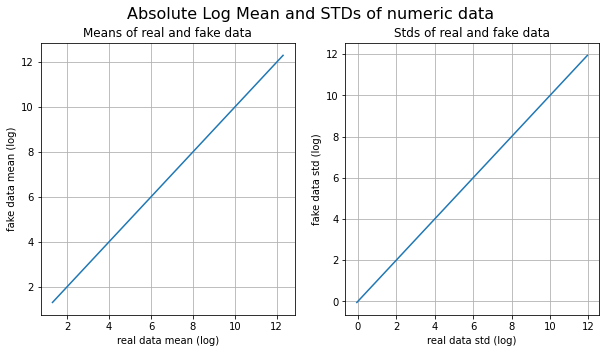

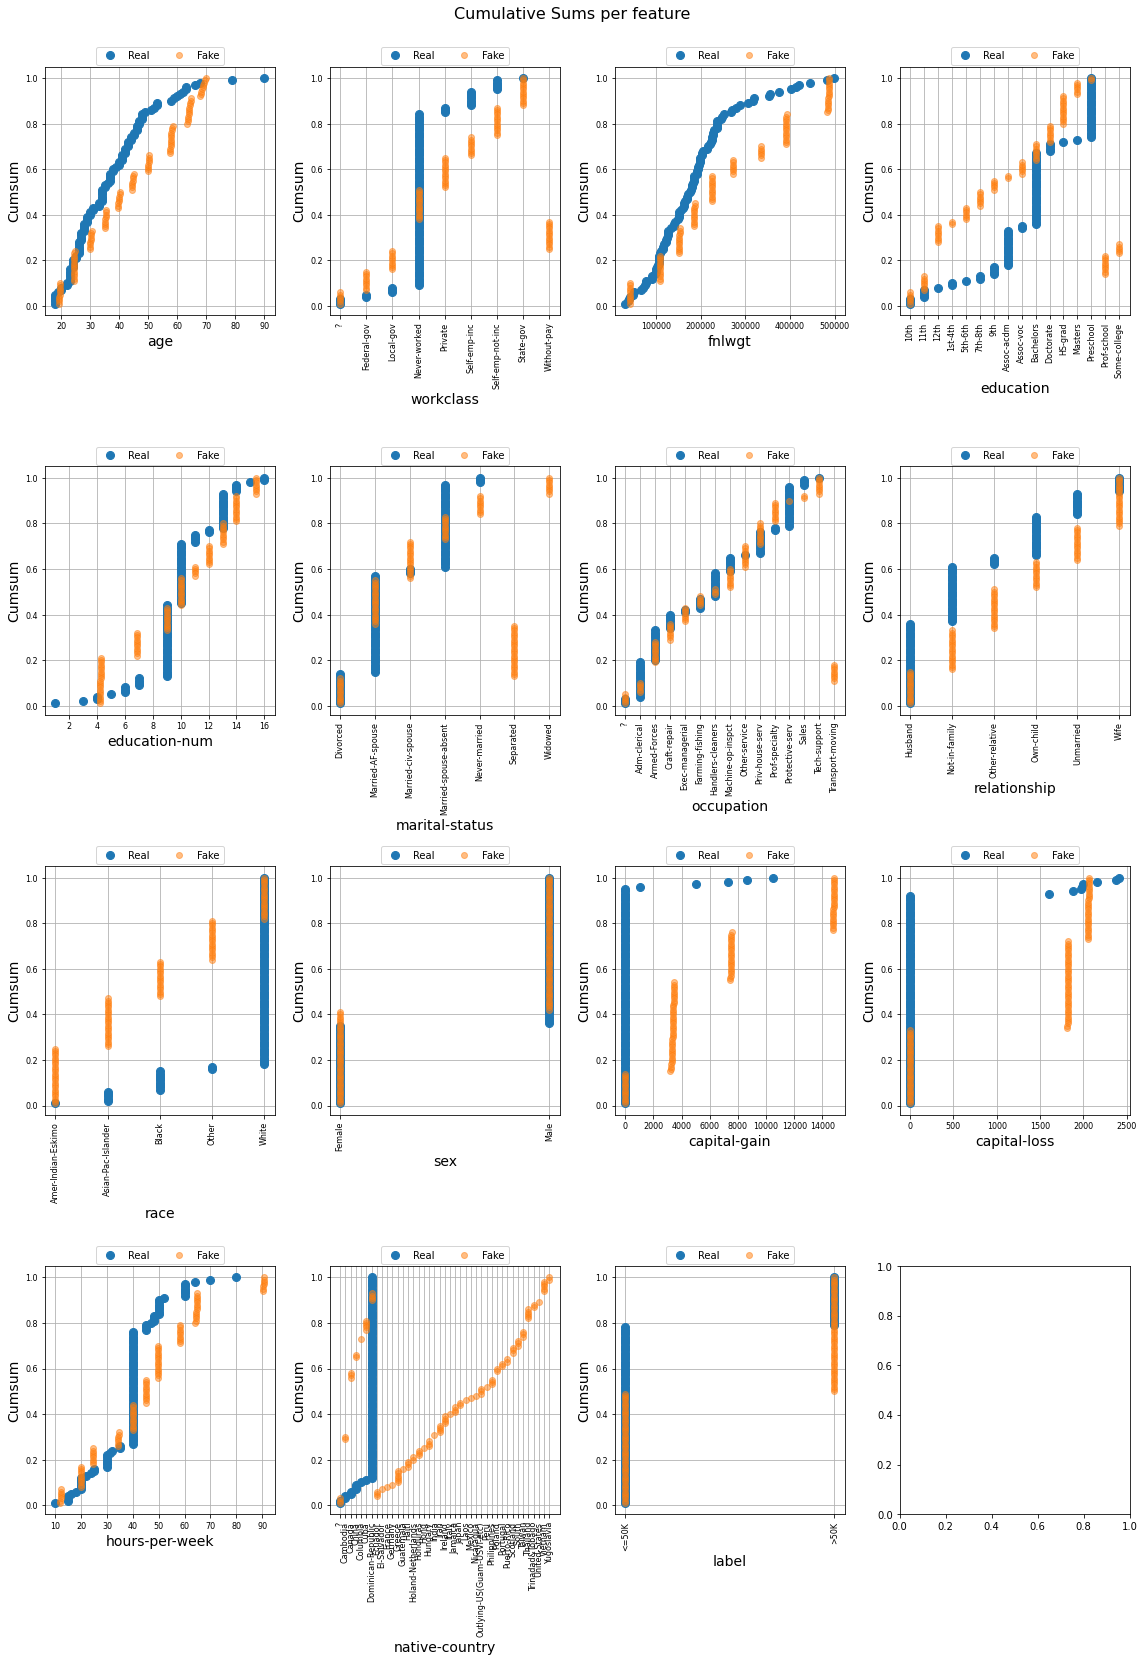

C:\Users\lenovo\AppData\Roaming\Python\Python39\site-packages\table_evaluator\table_evaluator.py:182: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(axes[i].get_xticklabels(), rotation='vertical')
C:\Users\lenovo\AppData\Roaming\Python\Python39\site-packages\table_evaluator\table_evaluator.py:182: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(axes[i].get_xticklabels(), rotation='vertical')
C:\Users\lenovo\AppData\Roaming\Python\Python39\site-packages\table_evaluator\table_evaluator.py:182: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(axes[i].get_xticklabels(), rotation='vertical')
C:\Users\lenovo\AppData\Roaming\Python\Python39\site-packages\table_evaluator\table_evaluator.py:182: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(axes[i].get_xticklabels(), rotation='vertical')
C:\Users\lenovo\

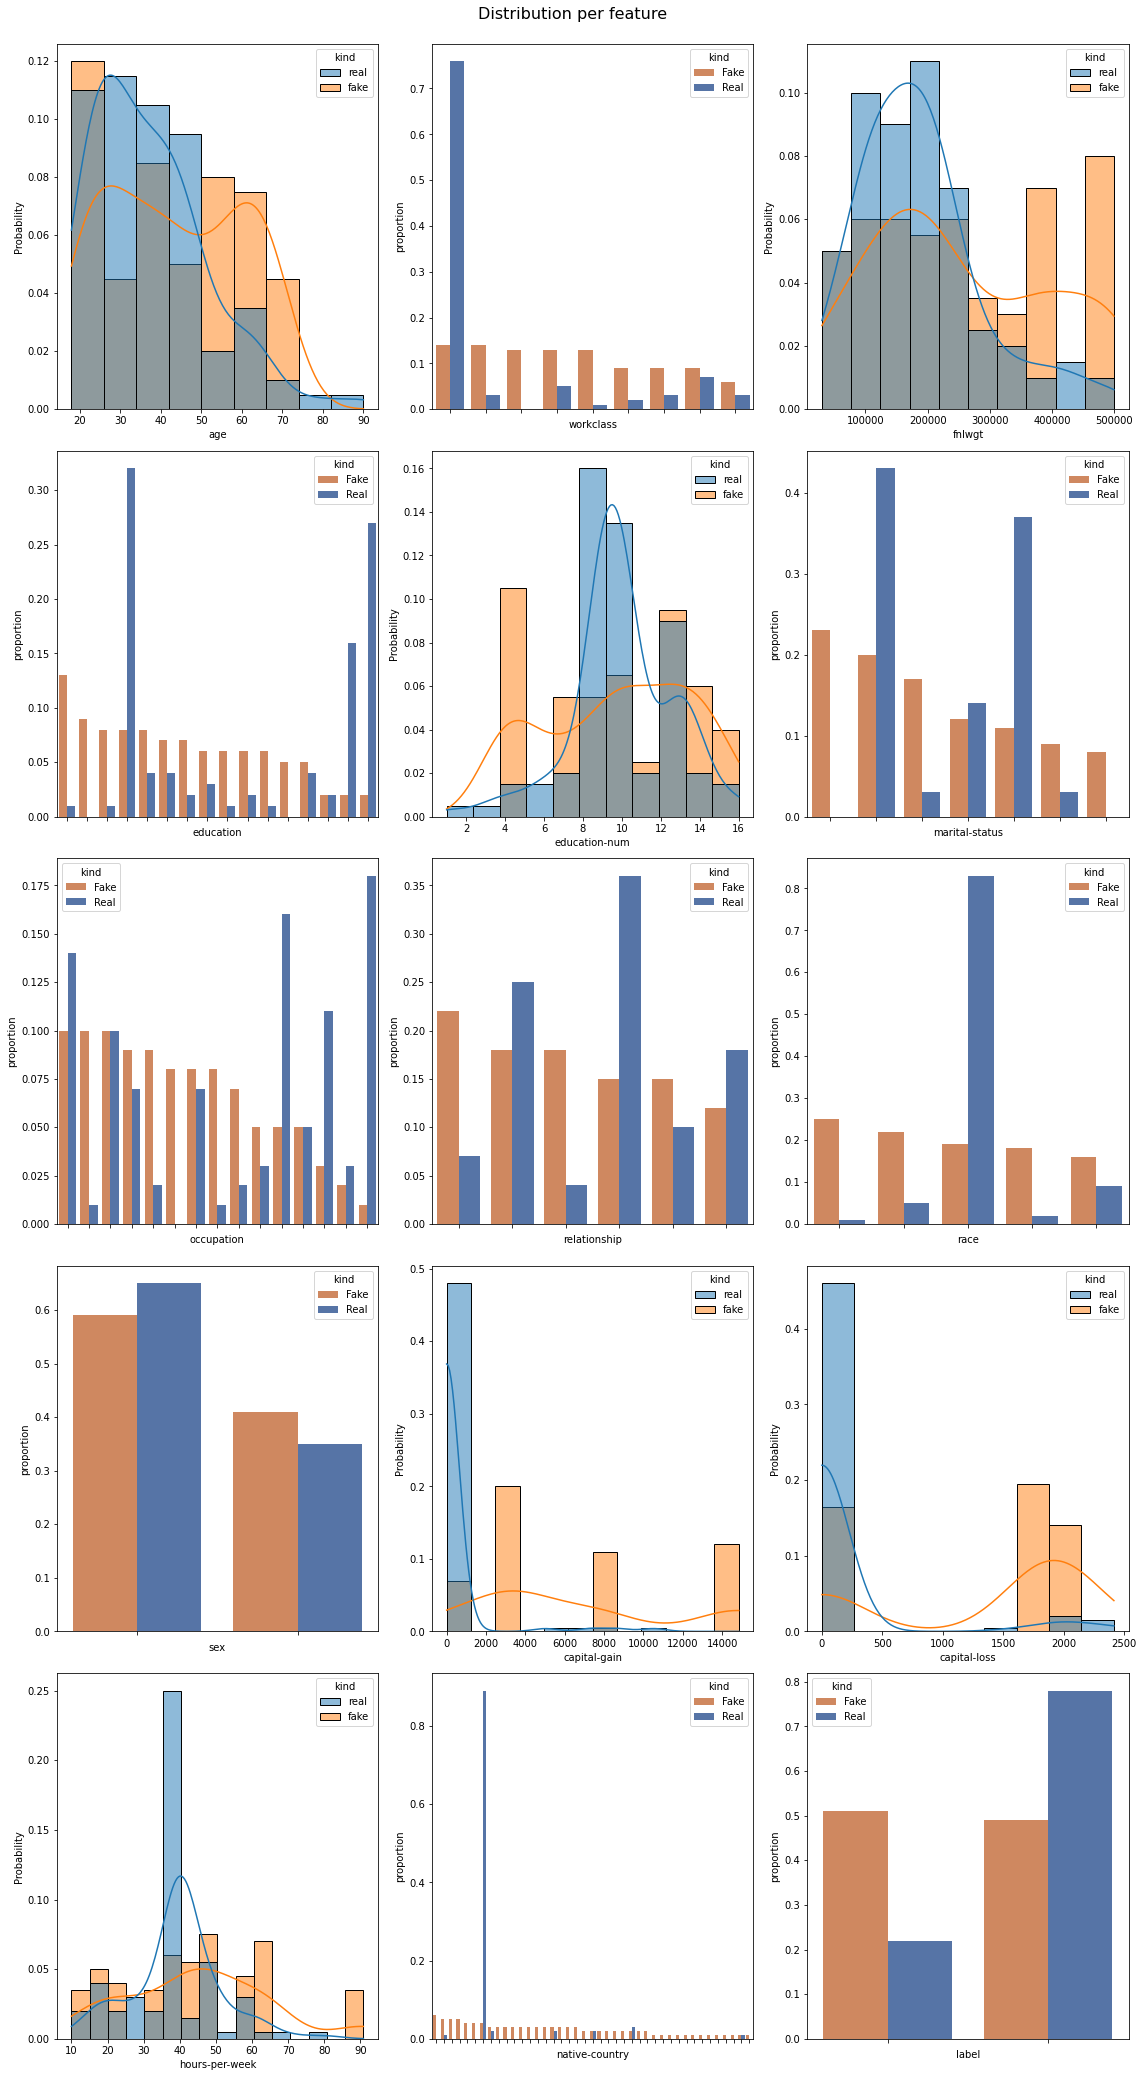

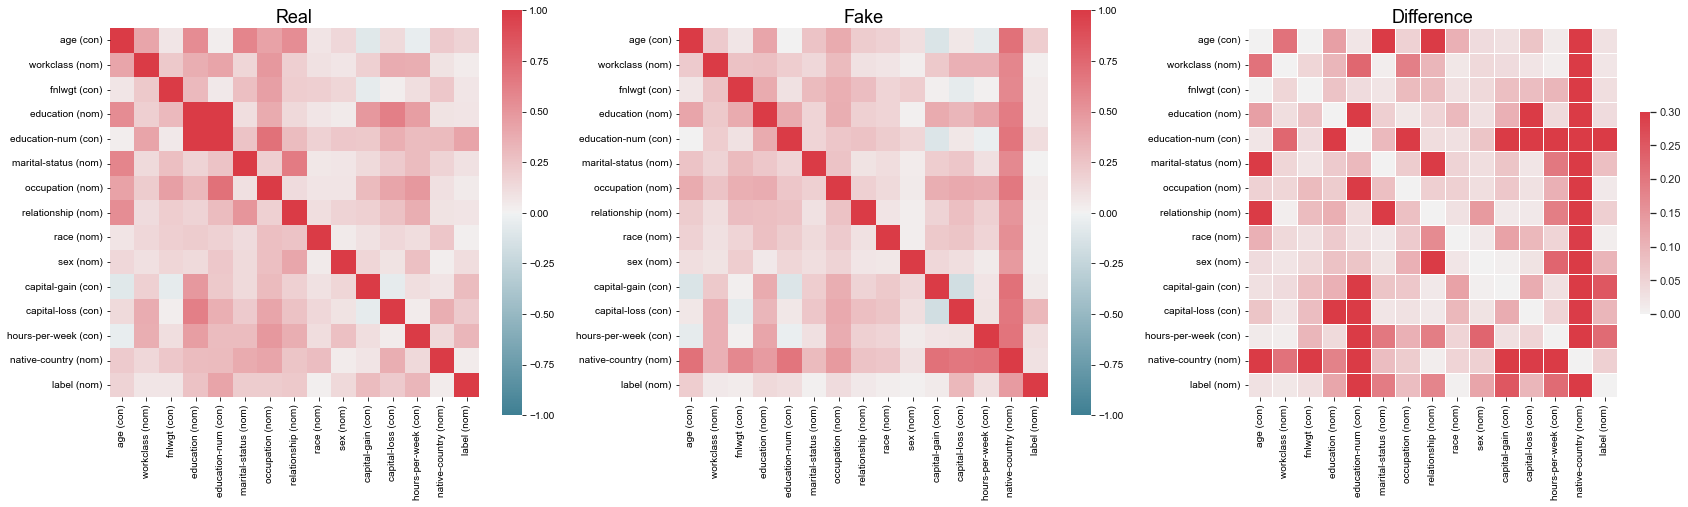

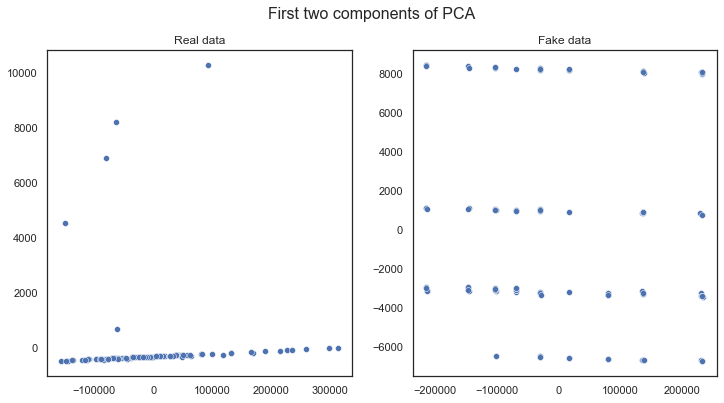

In [18]:
from table_evaluator import TableEvaluator
result = synthesizer.sample(100)
table_evaluator = TableEvaluator(data, result)
table_evaluator.visual_evaluation()

In [9]:
# # data, transformer, fit, transform -> train_data
# data, metadata = load_dataset(dataset='adult', modality='single-table')

# metadata_obj = SingleTableMetadata.load_from_dict(metadata)
# data_dict = metadata_obj.columns
# categorical_columns = [column for column, info in data_dict.items() if info.get('sdtype') == 'categorical']
# categorical_columns_tuple = tuple(categorical_columns)
# ordinal_columns = [column for column, info in data_dict.items() if info.get('sdtype') == 'ordinal']
# ordinal_columns_tuple = tuple(ordinal_columns)
# df = pd.DataFrame(data)
# meta = []
# for index in df:
#     column = df[index]

#     if index in categorical_columns:
#         mapper = column.value_counts().index.tolist()
#         meta.append({
#             "name": index,
#             "type": CATEGORICAL,
#             "size": len(mapper),
#             "i2s": mapper
#         })
#     elif index in ordinal_columns:
#         value_count = list(dict(column.value_counts()).items())
#         value_count = sorted(value_count, key=lambda x: -x[1])
#         mapper = list(map(lambda x: x[0], value_count))
#         meta.append({
#             "name": index,
#             "type": ORDINAL,
#             "size": len(mapper),
#             "i2s": mapper
#         })
#     else:
#         meta.append({
#             "name": index,
#             "type": CONTINUOUS,
#             "min": column.min(),
#             "max": column.max(),
#         })

# # fit
# n_clusters = 10
# eps = 0.005
# model = []

# output_info = []
# output_dim = 0
# components = []
# for id_, info in enumerate(meta):
#     if info['type'] == CONTINUOUS:
#         gm = BayesianGaussianMixture(
#             n_components=n_clusters,
#             weight_concentration_prior_type='dirichlet_process',
#             weight_concentration_prior=0.001,
#             n_init=1)
#         gm.fit(data.iloc[:, id_].values.reshape([-1, 1]))
#         model.append(gm)
#         comp = gm.weights_ > eps
#         components.append(comp)

#         output_info += [(1, 'tanh'), (np.sum(comp), 'softmax')]
#         output_dim += 1 + np.sum(comp)
#     else:
#         model.append(None)
#         components.append(None)
#         output_info += [(info['size'], 'softmax')]
#         output_dim += info['size']

# # transform
# values = []
# c_model = []
# for id_, info in enumerate(meta):
#     current = data.iloc[:, id_]
#     if info['type'] == CONTINUOUS:
#         current = current.values.reshape([-1, 1])

#         means = model[id_].means_.reshape((1, n_clusters))
#         stds = np.sqrt(model[id_].covariances_).reshape((1, n_clusters))
#         features = (current - means) / (4 * stds)

#         probs = model[id_].predict_proba(current.reshape([-1, 1]))

#         n_opts = sum(components[id_])
#         features = features[:, components[id_]]
#         probs = probs[:, components[id_]]

#         opt_sel = np.zeros(len(data), dtype='int')
#         for i in range(len(data)):
#             pp = probs[i] + 1e-6
#             pp = pp / sum(pp)
#             opt_sel[i] = np.random.choice(np.arange(n_opts), p=pp)

#         idx = np.arange((len(features)))
#         features = features[idx, opt_sel].reshape([-1, 1])
#         features = np.clip(features, -.99, .99)

#         probs_onehot = np.zeros_like(probs)
#         probs_onehot[np.arange(len(probs)), opt_sel] = 1
#         values += [features, probs_onehot]
#         c_model.append(None)
#     else:
#         label_encoder = LabelEncoder()
#         current_encoded = label_encoder.fit_transform(current)
#         col_t = np.zeros([len(data), info['size']])
#         col_t[np.arange(len(data)), current_encoded] = 1
#         c_model.append(label_encoder)
#         values.append(col_t)

# train_data = np.concatenate(values, axis=1)

C:\Users\lenovo\AppData\Roaming\Python\Python39\site-packages\sklearn\mixture\_base.py:268: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn(
C:\Users\lenovo\AppData\Roaming\Python\Python39\site-packages\sklearn\mixture\_base.py:268: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn(
C:\Users\lenovo\AppData\Roaming\Python\Python39\site-packages\sklearn\mixture\_base.py:268: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn(
C:\Users\lenovo\AppData\Roaming\Python\Python39\site-packages\sklearn\mixture\_base.py:268: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.wa

In [ ]:
# # inverse train_data -> df_t
# sigmas = None
# data_t = np.zeros([len(train_data), len(meta)])
# data_t = data_t.astype(object)

# st = 0
# for id_, info in enumerate(meta):
#     if info['type'] == CONTINUOUS:
#         u = train_data[:, st]
#         v = train_data[:, st + 1:st + 1 + np.sum(components[id_])]

#         if sigmas is not None:
#             sig = sigmas[st]
#             u = np.random.normal(u, sig)

#         u = np.clip(u, -1, 1)
#         v_t = np.ones((train_data.shape[0], n_clusters)) * -100
#         v_t[:, components[id_]] = v
#         v = v_t
#         st += 1 + np.sum(components[id_])
#         means = model[id_].means_.reshape([-1])
#         stds = np.sqrt(model[id_].covariances_).reshape([-1])
#         p_argmax = np.argmax(v, axis=1)
#         std_t = stds[p_argmax]
#         mean_t = means[p_argmax]
#         tmp = u * 4 * std_t + mean_t
#         data_t[:, id_] = tmp

#     else:
#         current = train_data[:, st:st + info['size']]
#         st += info['size']
#         data_t[:, id_] = np.argmax(current, axis=1)
#         label_encoder = c_model[id_]
#         d_int = data_t[:, id_].astype(int)
#         original_categories = label_encoder.inverse_transform(d_int)
#         data_t[:, id_] = original_categories
# df_t = pd.DataFrame(data_t)

In [10]:
# # data, BGMTransformer -> trans_data
# data, metadata = load_dataset(dataset='adult', modality='single-table')
# metadata_obj = SingleTableMetadata.load_from_dict(metadata)
# data_dict = metadata_obj.columns
# categorical_columns = [column for column, info in data_dict.items() if info.get('sdtype') == 'categorical']
# categorical_columns_tuple = tuple(categorical_columns)
# ordinal_columns = [column for column, info in data_dict.items() if info.get('sdtype') == 'ordinal']
# ordinal_columns_tuple = tuple(ordinal_columns)

C:\Users\lenovo\AppData\Roaming\Python\Python39\site-packages\sklearn\mixture\_base.py:268: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn(
C:\Users\lenovo\AppData\Roaming\Python\Python39\site-packages\sklearn\mixture\_base.py:268: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn(
C:\Users\lenovo\AppData\Roaming\Python\Python39\site-packages\sklearn\mixture\_base.py:268: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn(
C:\Users\lenovo\AppData\Roaming\Python\Python39\site-packages\sklearn\mixture\_base.py:268: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.wa

In [11]:
# # trans_data mean var -> syn_data
# # calculate mean and covariance
# m = trans_data.shape[0]
# n = trans_data.shape[1]
# # yT = y_train.reshape(-1, 1)
# # orgIris = np.concatenate((X_train, yT), axis=1)
# mean_real = [np.mean(trans_data[:,i]) for i in range(0,n)]
# # print(mean_real)
# vars_real = [np.var(trans_data[:,i]) for i in range(0,n)]
# # print(vars_real)
# cov_real = np.cov(trans_data.T)
# # print(cov_real)

# # using PCA to generate synthetic dataset
# l, v = np.linalg.eig(cov_real)
# # calculate the largest three eigenvalues and transformation matrix
# e=3 # 3 eigenvalues
# max_index = np.argpartition(l,-e)[-e:]
# matrix = np.zeros((n,e))
# for i in range(e-1,-1,-1):
#     matrix[:,e-1-i] = v[:,max_index[i]]

# # calculate new mean and variance
# nmean = np.dot(mean_real, matrix)
# nvar = np.dot(vars_real, matrix*matrix)
# k = np.sqrt(nvar)

# # sample for the new features
# s0 = np.random.normal(nmean[0], k[0], 10)
# s1 = np.random.normal(nmean[1], k[1], 10)
# s2 = np.random.normal(nmean[2], k[2], 10)
# new_features = np.zeros([10, 3])
# for i in range(e):
#     s = np.random.normal(nmean[i], k[i], 10)
#     new_features[:,i]=s
# # make Cartesian production
# A = list(itertools.product(*new_features.T))

# # convert them back
# syn_data = np.dot(A, matrix.T)

C:\Users\lenovo\AppData\Local\Temp/ipykernel_10696/3806487402.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
  matrix[:,e-1-i] = v[:,max_index[i]]


In [21]:
# n_data = []
# output_info = transformer.output_info
# df_fake = pd.DataFrame(syn_data)
# for u in range(n):
#     fakeact = apply_activate(df_fake, output_info)
#     n_data.append(fakeact.detach().cpu().numpy())
# n_data = np.concatenate(n_data, axis=0)
# n_data = n_data[:n]
# # fake = transformer.inverse_transform(syn_data, None)

In [ ]:
# # test itertools
# new_features = np.zeros([10, e])
# for i in range(e):
#     s = np.random.normal(nmean[i], k[i], 10)
#     new_features[:,i]=s
# A = list(itertools.product(new_features[i] for i in range(e)))